<a href="https://colab.research.google.com/github/AliAlBadra/KerasTFImageClassificationCNN/blob/main/CellSeg_Import_Model_UNet_ResNet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prepare Environment

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install patchify
!pip install scikit-learn==1.0.0
!pip install split-folders
!pip install gast==0.3.2
!pip install six==1.15.0
!pip install folium==0.2.1
!pip install imgaug==0.2.5
!pip install 'h5py<3.0.0'

     |████████████████████████████████| 50 kB 4.6 MB/s 
     |████████████████████████████████| 421.8 MB 29 kB/s 
     |████████████████████████████████| 3.8 MB 31.8 MB/s 
     |████████████████████████████████| 448 kB 44.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=ff4587c8161e28db0a0bb2749ca73d6f83e203114a1a21c7626fb617d0887596
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

     |████████████████████████████████| 377 kB 5.5 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


     |████████████████████████████████| 23.1 MB 25.0 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
  Created wheel for gast: filename=gast-0.3.2-py3-none-any.whl size=9694 sha256=5893303a5c2430ba161688d2525fbbe75f31ae0c80ee52ac08be7e1cf6de7f04
  Stored in directory: /root/.cache/pip/wheels/9b/7b/89/365a82e420c11db9b43d34918045faa8004748a1d97597930d
Successfully built gast
  Attempting uninstall: gast
    Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.1.0 requires gast==0.2.2, but you have gast 0.3.2 which is incompatible.


     |████████████████████████████████| 69 kB 3.7 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=9126976b0f4cafdea75aa3cb1b56bb6b4d85ce380e2a3683c5816f51058b7f5d
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
     |████████████████████████████████| 562 kB 5.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=5278bcf181b2af11afdf72bd5c7b8d85d3c569dc8a1772e7eed0daf0efdac04c
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
     |██████████

In [1]:
cellseg_dir = '/content/drive/MyDrive/CellSeg/'
data_dir = cellseg_dir + "data/"
input_dir = data_dir + "input/"
original_input_dir = input_dir + "original/"
after_patchify_384_input_dir = input_dir + "after_patchify_384/"
after_patchify_256_input_dir = input_dir + "after_patchify_256/"
output_dir = data_dir + "output/"
full_model_dir = cellseg_dir + "model/full/"

#Import Model

In [2]:
from tensorflow import keras
model = keras.models.load_model(full_model_dir + "cellseg_25_epochs_RESNET_backbone_batch16_256.hdf5", compile=False)

#Data Generator

In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [4]:
# Define Generator for images and masks so we can read them directly from the drive. 

seed=24
batch_size= 4
n_classes=2

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.clip = False
from keras.utils import to_categorical

#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

train_img_path = output_dir + "256/train_images/"
train_mask_path = output_dir + "256/train_masks/"

val_img_path = output_dir + "256/val_images/"
val_mask_path = output_dir + "256/val_masks/"

In [5]:
#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc. 
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = to_categorical(mask, num_class)
    return (img,mask)

In [6]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    while True:
      img_data_gen_args = dict(horizontal_flip=True,
                        vertical_flip=True,
                        fill_mode='reflect')
      
      image_datagen = ImageDataGenerator(**img_data_gen_args)
      mask_datagen = ImageDataGenerator(**img_data_gen_args)
      
      image_generator = image_datagen.flow_from_directory(
          train_img_path,
          class_mode = None,
          batch_size = batch_size,
          seed = seed)
      
      mask_generator = mask_datagen.flow_from_directory(
          train_mask_path,
          class_mode = None,
          color_mode = 'grayscale',
          batch_size = batch_size,
          seed = seed)
      
      train_generator = zip(image_generator, mask_generator)
      i = 0
      for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [7]:
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=n_classes)
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=n_classes)

Found 648 images belonging to 1 classes.
Found 648 images belonging to 1 classes.


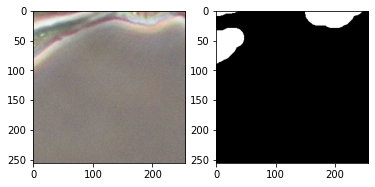

256 256 3


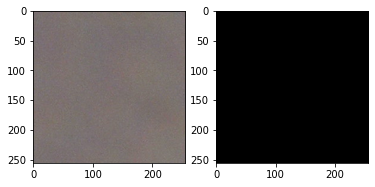

256 256 3


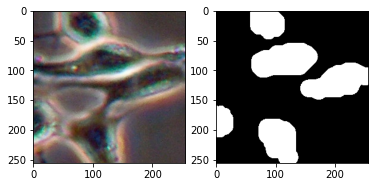

256 256 3


In [8]:
#Make sure the generator is working and that images and masks are indeed lined up. 
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()
    height, width, channels = image.shape
    print (height, width, channels)

Found 216 images belonging to 1 classes.
Found 216 images belonging to 1 classes.


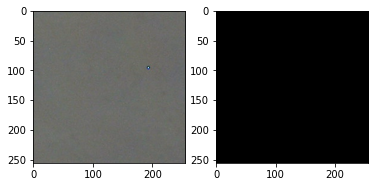

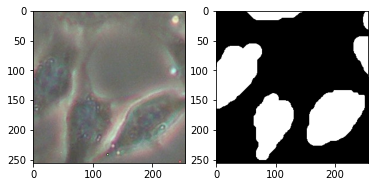

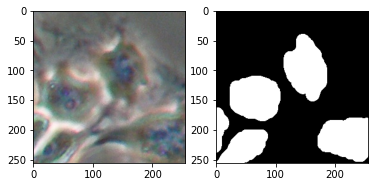

In [9]:
x_val, y_val = val_img_gen.__next__()

for i in range(0,3):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [10]:
#Define the model metrcis and load model. 

num_train_imgs = len(os.listdir(train_img_path+"train/"))
num_val_images = len(os.listdir(val_img_path+'val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

print("#Train Img: ", num_train_imgs)
print("#Val Img: ", num_val_images)
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)
n_classes=2

#Train Img:  648
#Val Img:  216
256
256
3


#Test Model Using Val Batches

Mean IoU = 0.88878715


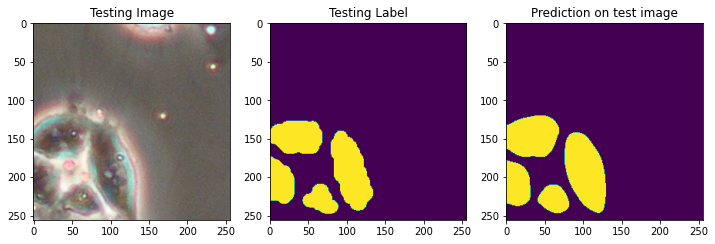

In [22]:
#batch_size=32 #Check IoU for a batch of images

#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

#Predictions on Full Images

In [12]:
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
from PIL import Image
import segmentation_models as sm

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import smooth_tiled_predictions
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [13]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

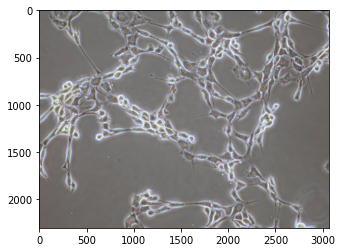

In [23]:
img = cv2.imread(data_dir + "test/exp0.png")  #N-34-66-C-c-4-3.tif, N-34-97-D-c-2-4.tif
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
input_img = preprocess_input(input_img)

original_mask = cv2.imread(data_dir + "test/exp0-mask.png")
original_mask = original_mask[:,:,0]  #Use only single channel...
# size of patches
patch_size = 256

# Number of classes 
n_classes = 2
plt.imshow(input_img)

In [24]:
###################################################################################
#Predict using smooth blending

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

100%|██████████| 8/8 [00:57<00:00,  7.25s/it]


In [25]:
final_prediction = np.argmax(predictions_smooth, axis=2)

#Save prediction and original mask for comparison
plt.imsave(data_dir+'test/exp0-prediction.jpg', final_prediction)
plt.imsave(data_dir+'test/exp0-original.jpg', original_mask)

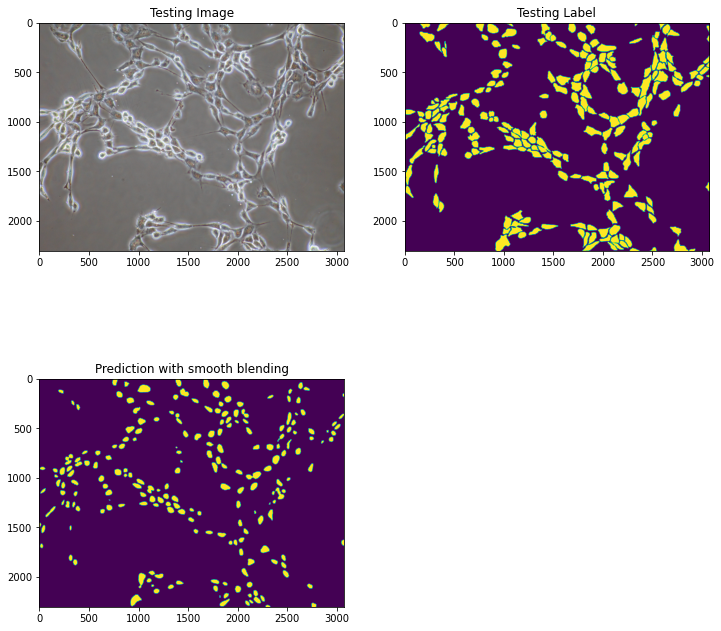

In [26]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()

#Calculate Test Metrics

Mean IoU = 0.741869


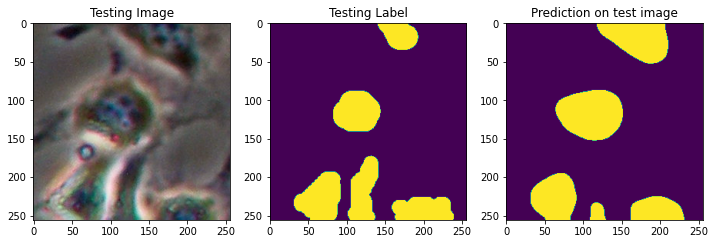

In [41]:
#Test generator using validation data.

test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################
#View a few images, masks and corresponding predictions. 
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()